# Collaborators:

- Niels Savvides
- Matisse Callewaert
- Thibaud Despriet
- Ilkay Yuksel

# Lab V: Classification

## Define Imports

In [22]:
import cv2
import numpy as np
from glob import glob
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.ensemble import RandomForestClassifier
import cv2
import numpy as np
from glob import glob
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

## Helper Functions

In [23]:
def apply_filters(image, filters):
    filtered_images = []
    for filter_kernel in filters:
        # Apply filter to each channel and combine the results
        filtered_channels = [cv2.filter2D(image[:, :, channel], ddepth=-1, kernel=filter_kernel, borderType=cv2.BORDER_REPLICATE) for channel in range(3)]
        filtered_image = np.stack(filtered_channels, axis=-1)
        filtered_images.append(filtered_image)
    return filtered_images

def generate_DoG_filters(scales=[1, 2], orientations=[0, 30, 60, 90, 120, 150]):
    filters = []
    size = 28 
    for scale in scales:
        for orientation in orientations:
            # Create a meshgrid
            x, y = np.meshgrid(np.linspace(-5*scale, 5*scale, size),
                               np.linspace(-5*scale, 5*scale, size))
            
            # Rotate x, y coordinates for the orientation
            theta = np.deg2rad(orientation)
            xr = x * np.cos(theta) + y * np.sin(theta)
            yr = -x * np.sin(theta) + y * np.cos(theta)
            
            yr /= 2

            # Generate the Gaussian filter and its derivative
            gauss = np.exp(-(xr**2 + yr**2) / (2 * scale**2))
            gauss_deriv = -xr / scale**2 * gauss

            # Normalize the filter
            gauss_deriv -= np.mean(gauss_deriv)
            gauss_deriv /= np.std(gauss_deriv)

            filters.append(gauss_deriv)

    return filters

def predict_with_visualization(source, classifier, filters):
    im = cv2.imread(source, cv2.IMREAD_COLOR).astype(np.float32)
    im /= 255.0 
    
    # Apply DoG filters and prepare the feature vector for prediction
    filter_responses = apply_filters(im, filters)
    feature_vector = np.dstack([im] + filter_responses)
    feature_vector_flat = feature_vector.reshape(-1, feature_vector.shape[2])  # Flatten for prediction
    
    # Predict
    plab = classifier.predict(feature_vector_flat)
    plab_image = plab.reshape(im.shape[0], im.shape[1])  # Reshape the predictions to the image size
    
    # Visualization
    plab_color = np.zeros_like(im)
    plab_color[plab_image == 255] = [0, 1, 0]  # Green for sky
    plab_color[plab_image == 0] = [1, 0, 0]    # Red for non-sky

    # Show original image with overlay of prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.imshow(plab_color, alpha=0.5)  # Overlay with prediction
    plt.show()

def process_images(source_path, label_path, model):
    filters = generate_DoG_filters()
    sources = sorted(glob(source_path))
    labels = sorted(glob(label_path))

    features = []
    values = []

    for source, label in zip(sources, labels):
        im = cv2.imread(source, cv2.IMREAD_COLOR).astype(np.float32)
        im /= 255.0  # Normalize
        lab = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

        filter_responses = apply_filters(im, filters)
        
        # Stack filter responses along with the original channels
        feature_vector = np.dstack([im] + filter_responses)
        
        # Flatten the feature vector
        feature_vector_flat = feature_vector.reshape(-1, feature_vector.shape[2])

        features.append(feature_vector_flat)
        values.append(lab.flatten())

    features = np.concatenate(features)
    values = np.concatenate(values)

    # Filter pixels for training
    which = np.where((values == 0) | (values == 255))[0]
    features = features[which, :]
    values = values[which]

    # Train QDA classifier
    qda = model
    qda.fit(features, values)
    print(f'Mean training accuracy: {qda.score(features, values)}')

    # Prediction and visualization
    for source in sources:
        predict_with_visualization(source, qda, filters)

## 1: Feature vectors

Many applications require observations to be assigned to categories or classes. For example, a doctor may
look at a magnetic resonance image (MRI) of a patient’s brain and classify the brain as healthy or patho-
logical based on the prevalence or absence of certain distinctive qualities or features. In computer vision,
such classification problems are very common. In order to automate the assignment of a class label to an
observation, typically a series of numbers is first calculated that describe the presence of features in the
observation. This set of descriptive numbers is called a feature vector. Features may relate to average
color values, presence of edges, strength of texture, ... The feature vectors can be seen as data points in a
multidimensional space.
An expert will then typically label part of the data, i.e. he will manually indicate the classes to which
that data belongs. A multitude of machine learning algorithms exists to then define a set of rules which
determine the most likely class label for every feature vector. Finding these rules is referred to as training
the classifier.

## 2: Linear and quadratic discriminant analysis

A naive way to classify multidimensional data is to determine the center of gravity of every class (the average
feature vector for all members of this class) and then assign each data point to the closest class. This has
the downside that it only works when the spread of the data is roughly uniform in every dimension. If one
field in the feature vector is a number between 0 and 1, but another field is between 0 and 1000000, finding
the closest class center will largely ignore the first field.
**Linear Discriminant Analysis** (LDA) overcomes this problem by calculating the distribution in each
dimension, and possible correlations between variables. The data is then projected to a lower dimensional
space spanned by new, independent features that are linear combinations of the original features. This
space is then carved into classes by linear decision surfaces (e.g. planes in three dimensions, lines in two
dimensions). An example is shown in Figure 1.
**Quadratic Discriminant Analysis** (QDA) is very similar, but with quadric decision surfaces. This is more
powerful especially when some classes are very compact in the independent feature space while others have
much larger variety in their feature vectors.
On Ufora you can find classify_skypix.py, a very basic pixel classifier that attempts to determine if
a pixel belongs to the sky or not based on its red, green and blue values. Make sure you understand what
happens:

- pixel data is labeled as white (sky), black (not sky) or do-not-care (anything else) in the masks provided
for two images,

- a QDA classifier is trained on the labeled sky and non-sky pixels of these two images,

- the classifier is used to predict where the sky is in both the two training images and two non-training
images

### Exercise 1:

The color based classifier makes many mistakes in the last two images, notably the white car and the road
marks are mislabeled. Color by itself is not a powerful enough feature to segment the sky. In this ex-
ercise, you will add texture features to the classifier. Make a set of DoG (derivative of Gaussian) filters,
using the code from Lab 5 exercise 10. You will use it to extend the three-dimensional feature vector in
classify_skypix.py

### Assignment 1

**Make a filterbank of DoG filters (derivative of Gaussian) in 2 scales and 6 orientations (so 12 filters in total). Visualize the filters as in Figure 2.**

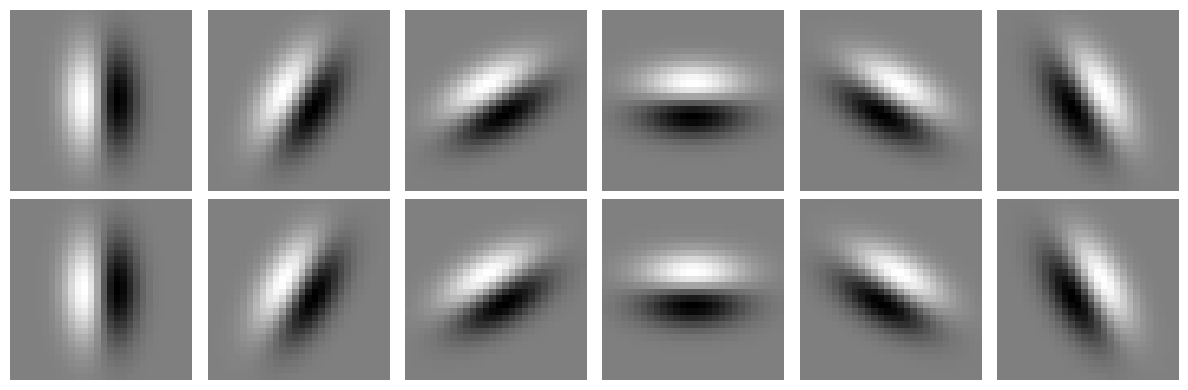

In [24]:
# Generate DoG filters
filters = generate_DoG_filters()

# Visualize the filters
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for ax, filter in zip(axes.ravel(), filters):
    ax.imshow(filter, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Assignment 2
- Filter road*.png with each of the filters. This gives you 12 filter response images. Make sure they are
floating point and contain negative values!
- Append the 12 filter response images to the blue, green and red channels to make a 15-channel image,
from which you can extract a 15-dimensional feature vector for each pixel.
- Train and test a new QDA classifier on the 15-dimensional feature vectors of all pixels of all four
images.

Show the classification result in your report.

c:\ProgramData\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Mean training accuracy: 0.9775142286879439


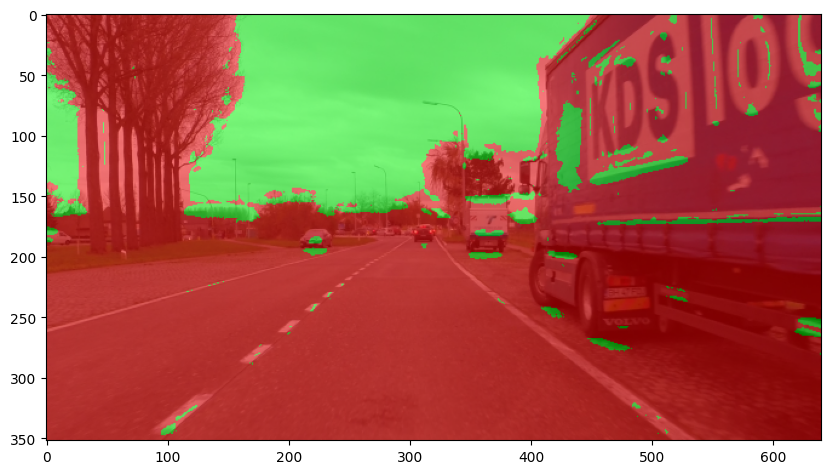

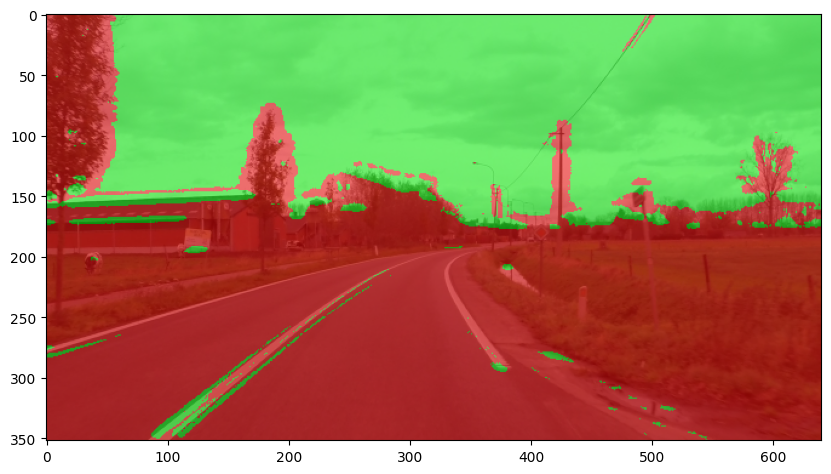

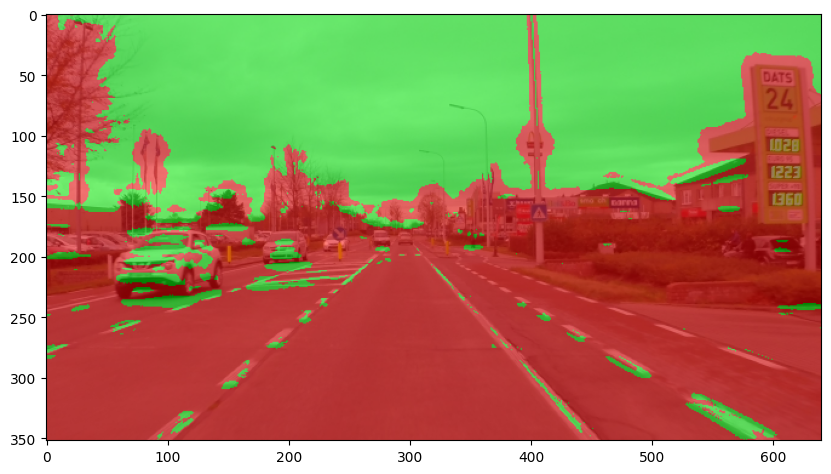

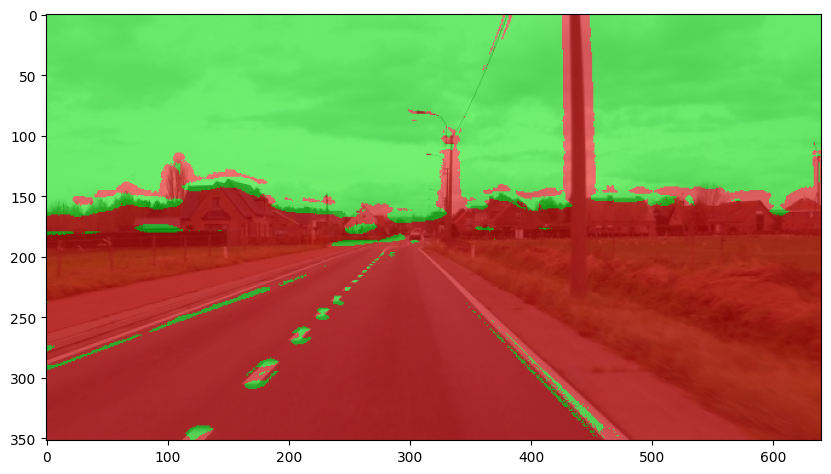

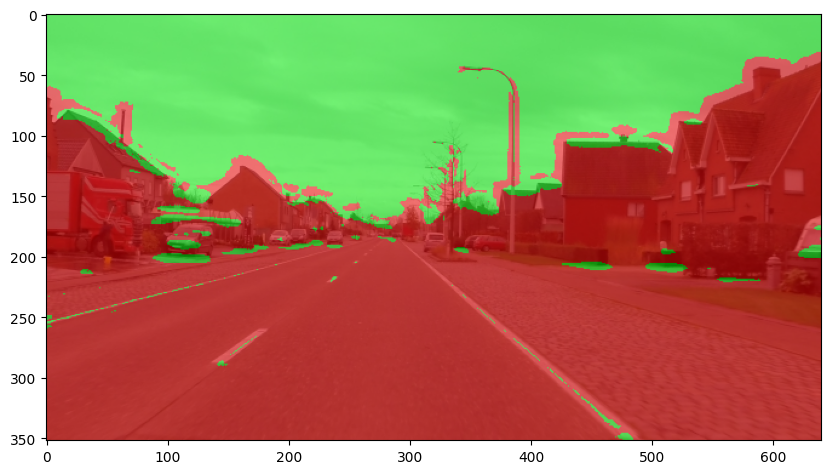

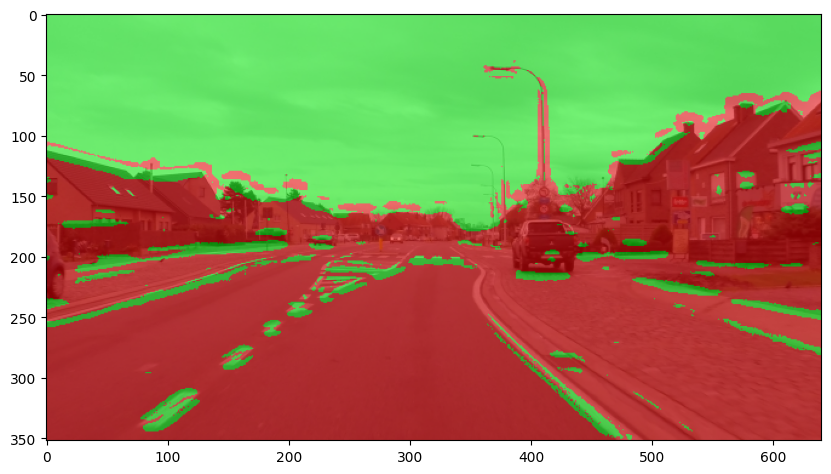

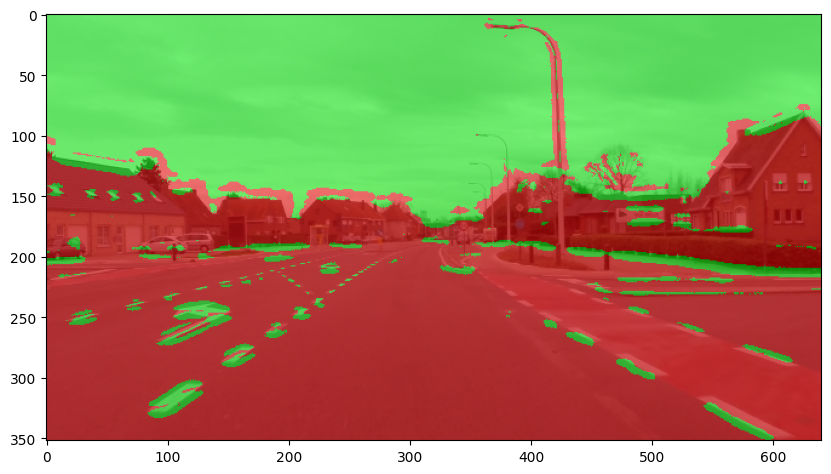

In [25]:
sources = "source_images/road?.png"
labels = "source_images/road?_skymask.png"
qda = QuadraticDiscriminantAnalysis()

process_images(sources, labels, qda)

## 3: Random Forest

A random forest classifier is a classifier that consists of a number of decision trees. Each decision tree
makes a hierarchical set of decisions, each decision based on a simple criterion on only a few feature values,
to arrive at a class label for the full feature vector. The random forest introduces random variations in
the construction of the trees and takes a majority vote of their outcomes. This solves a major drawback
of decision trees: their poor generalization to data slightly dissimilar from the training data. The main
advantage of a random forest over a decision surface based classifier like QDA is that the class samples do
not need to form a contiguous space. When there are groups of samples with the same label but scattered
in different parts of the multi-dimensional space, the decision trees can carve out these parts. Discriminant
analysis on the other hand will calculate the centroid of all the samples of the same label, and this centroid
may be far removed from all the samples if the data is not contiguous!

### Exercise 2:

**Replace the QDA classifier you trained in Exercise 1 with a random forest classifier. Pay
attention to the main parameters:**

**- the number of decision trees, controlling the overall complexity of the classifier (related to the com-
plexity of the data)**
**- the minimum leaf size, which controls how many samples must be grouped together as a minimum at
the end of each decision tree (usually specified as a fraction of the total data).**

Mean training accuracy: 0.9996121285255227


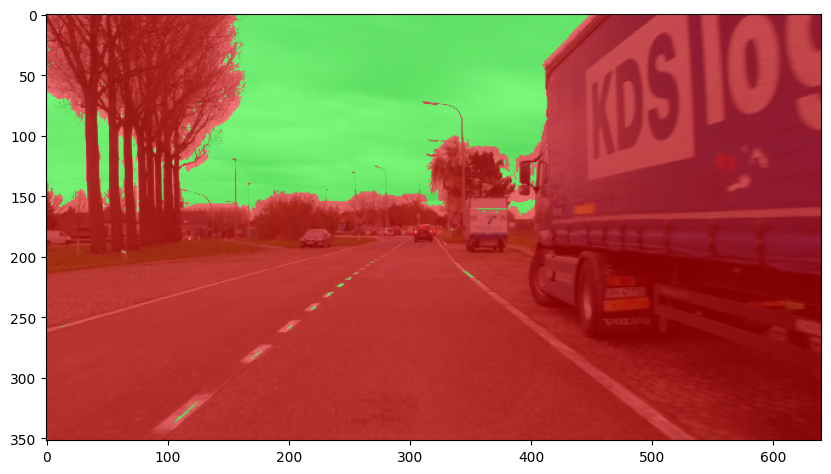

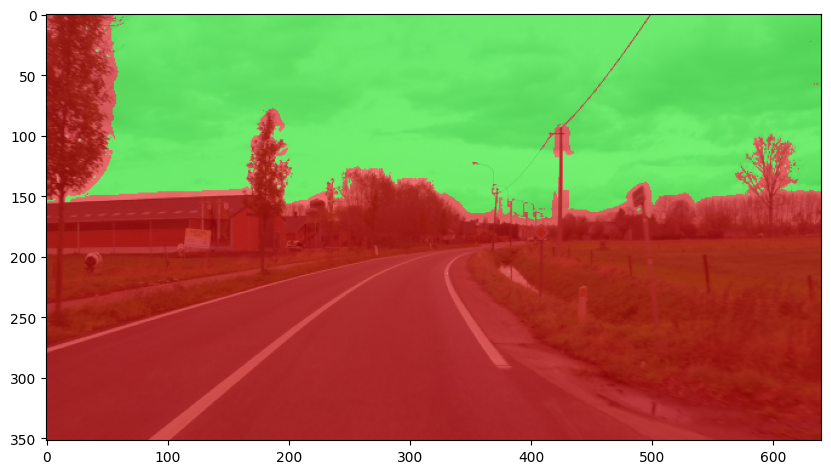

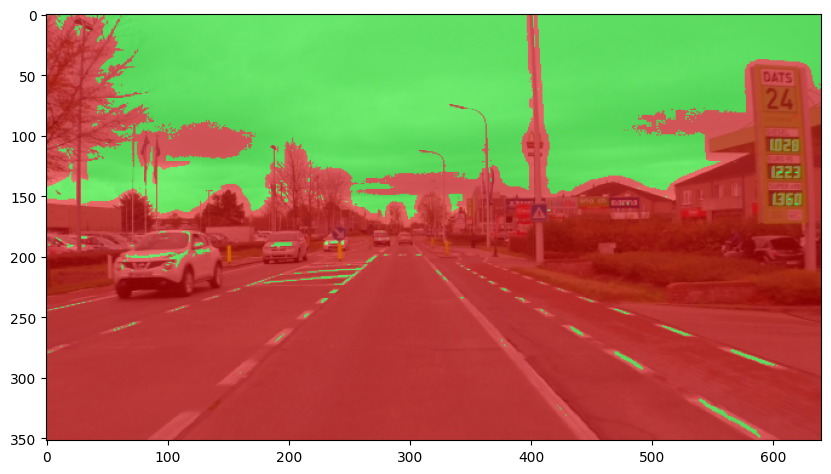

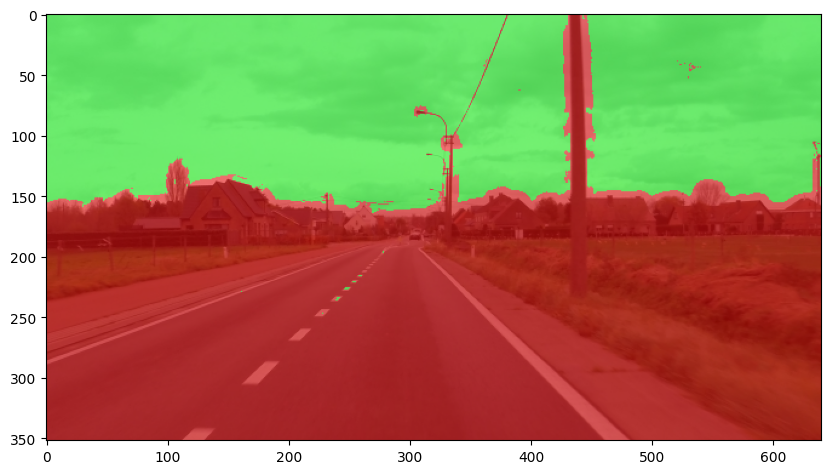

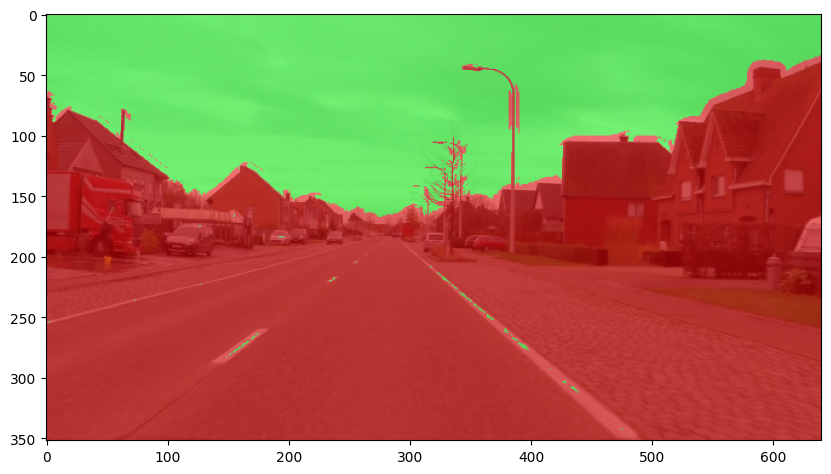

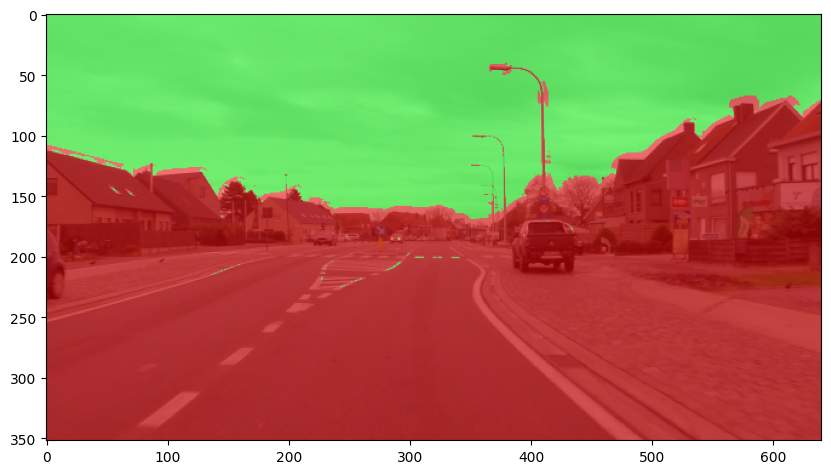

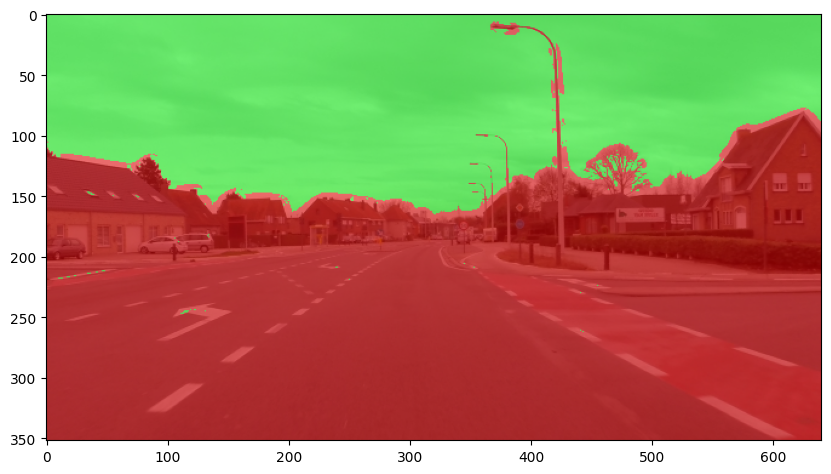

In [26]:
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
process_images(sources, labels, rf_classifier)

**Show the classification result in your report.**

#### Question 1:

**Does the RF classifier outperform the QDA classifier on the sky pixel classification problem?**

Indeed, the outcomes are more consistent, and the model significantly reduces false detections of road markings.

## Deep Learning

In the last decade, traditional machine learning classifiers have been gradually superceded by Artificial
Neural Networks (ANNs or simply NNs) for complex classification problems. Neural networks are inspired
by the human brain, which is an enormous collection of interconnected neurons which continuously adapt
their connections to learn to solve new problems. In an ANN, each neuron has a number of inputs, and
calculates its output as a weighted sum of these inputs. Several layers of neurons are typically used between
the input features and the the output prediction, so the neural network is capable of computing intermediate
representations (analogous to feature detection) and modeling relationships between the data at many levels
(low-level features to high-level, more abstract semantic interpretations).
Neural networks need to be trained: the weights of all the interconnections must be adjusted so that the
output approximates the desired result. This is achieved by a technique called backpropagation. Essentially,
the gradient of each of the output nodes with respect to the final prediction is determined, i.e., the derivative
of the node’s output with respect to each of its input node connections. Then the gradients of each of those
input nodes with respect to their input node connections are calculated, and this process is repeated until
the gradients have been calculated up to the first layer. These gradients describe how the output changes
with relation to each of the weights in the network. During each training step, the weights are adjusted with
an amount proportional to this gradient so that the output evolves towards the desired prediction. To ensure
the network does not get stuck into a local optimum, the steps are small, and different random samples are
used to calculate the gradient in each step. This way, the network hopefully converges towards a global
optimum.

### Exercise 3:

### Assignment 4

Replace the classifier you made in Exercise 15 with a neural network. You can use the
MLPClassifier from sklearn. Pay special attention to the following parameters:

- number of layers,
- number of neurons in each layer,
- learning rate of the optimizer,
- size of the training batches,
- number of training epochs

Ensure that your network has converged to a global optimum. Not that the training process is in many ways
stochastic, and multiple runs with identical parameters do not necessarily produce the same network! Show
the classification result in your report.

Iteration 1, loss = 0.03549750
Iteration 2, loss = 0.00740548
Iteration 3, loss = 0.00591619
Iteration 4, loss = 0.00483403
Iteration 5, loss = 0.00413960
Iteration 6, loss = 0.00387662
Iteration 7, loss = 0.00374658
Iteration 8, loss = 0.00335688
Iteration 9, loss = 0.00341559
Iteration 10, loss = 0.00322647


c:\ProgramData\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean training accuracy: 0.9994801444821242


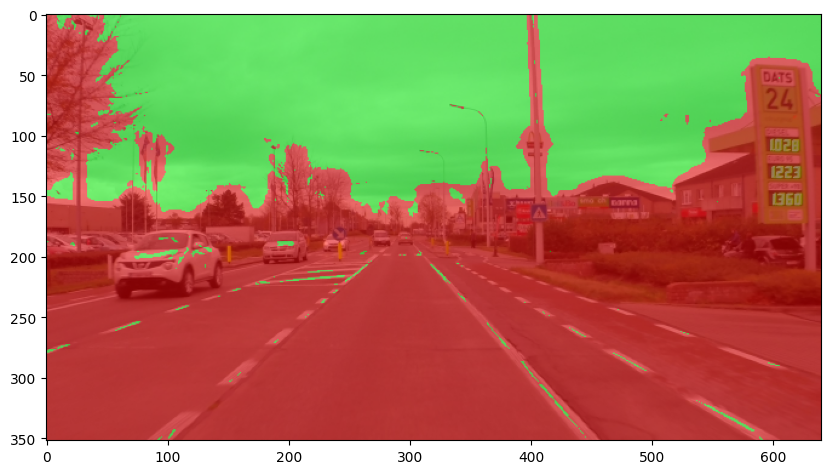

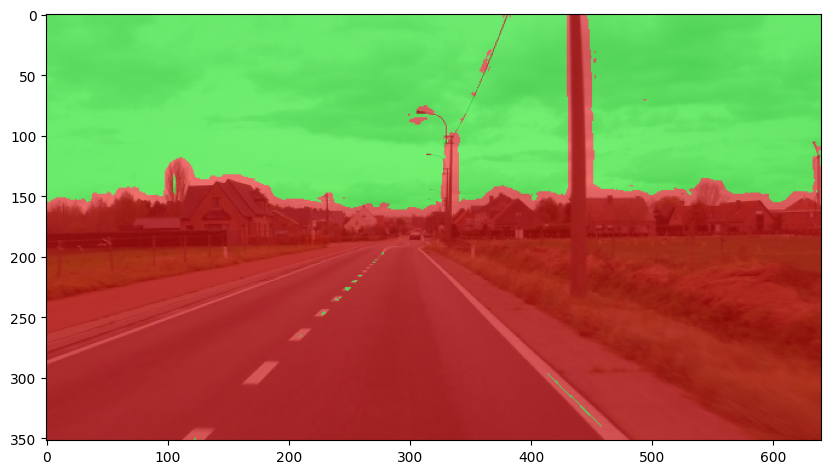

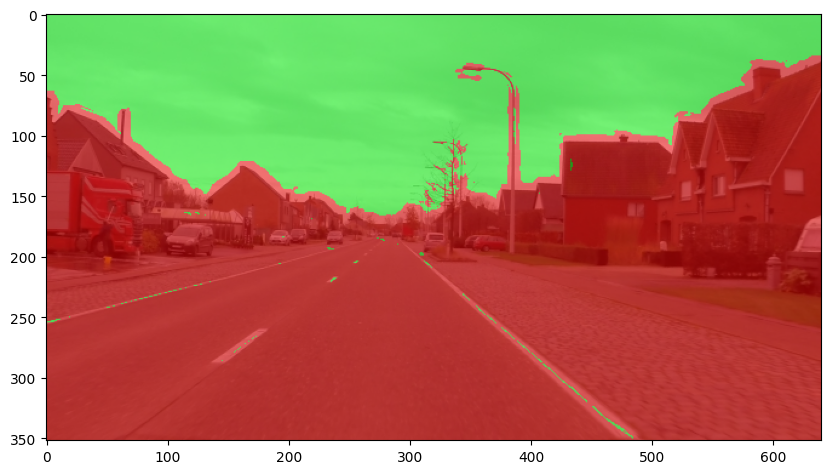

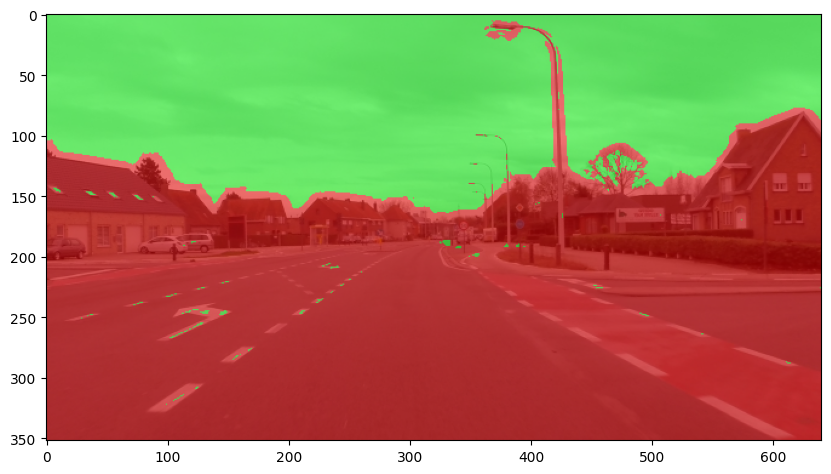

In [28]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), 
                               learning_rate_init=0.001,     
                               batch_size=64,                
                               max_iter=10,                  
                               solver='adam',                
                               verbose=True,                 
                               tol=1e-4,                     
                               n_iter_no_change=5)           

process_images(sources, labels, mlp_classifier)

#### Question 2:

**How does this classifier perform compared to the QDA classifier you made earlier? Do you see
overfitting, i.e., good performance on the training data but poor performance on unseen data?**

To see if the model overfits, we can predict on unseen data. For this we used the following image from the internet:

**Original Image**

<img src="source_images/road_unseen.png" alt="Original Image" width="640" height="480"/>

**Predicted Image**

<img src="source_images/road_unseen_prediction.png" alt="Predicted Image" width="640" height="480"/>


This was done using the following code:

```py
predict_with_visualization("source_images/road_unseen.png", mlp_classifier, filters)
```

The **Neural Network** consistently outperforms the QDA Classifier, especially in accurately identifying road markings—a task at which the QDA Classifier frequently falters. Despite the **Neural Network's** overall superior performance, its effectiveness is markedly reduced in scenarios where the sky is **blue** (or exhibits other colors), or when reflections are present in the image. These conditions lead to significant inaccuracies.

#### Question 3:

**Analyse the remaining errors in the prediction of your three classifiers. Can you think of a
simple extra feature that may help classification?**

Initially, we considered leveraging texture contrast alongside the response of DoG filters. Measuring contrast between various sections of an image could aid in identification, as areas of high contrast often signal edges or transitions between entities and the sky, potentially facilitating the differentiation of the sky from other objects. However, this approach seemed overly simplistic, given that road markings and similar elements would become more conspicuous, potentially leading to misclassifications. A different strategy was necessary.

Incorporating depth information presents a more promising solution. Depth cues can distinguish between objects based on their distance from the viewer. Typically, air exhibits consistent or negligible depth information in contrast to tangible objects. Therefore, adding a "depth" feature could significantly enhance the application's ability to accurately identify sky regions.

Note: Integrating a depth feature will undoubtedly improve performance, though it won't resolve all challenges. Consider reflections, for example; they will continue to present a difficult case to handle effectively.